<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd_(further_work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd%20(further%20work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To suppress tokenizer parallelism warnings

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

In [3]:
!pip install datasketch
from datasketch import MinHash, MinHashLSH
from datasets import Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 4.6 MB/s eta 0:00:00


In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

In [5]:
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
import torch
import torch.nn as nn
from transformers import XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding

In [6]:
import warnings
from transformers import logging
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

In [7]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Data Loading

In [8]:
#!pip install pyarrow

In [9]:
df = pd.read_parquet("0000.parquet")  # Let pandas choose the engine
df.head()

,document_name,words,pos_tags,met_type,meta
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[],"[N/A, N/A, N/A]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."


In [10]:
df = df.drop(columns='meta')  # Drop unnecessary column

In [11]:
df.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[]
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."


## filtering metaphor types

In [12]:
# display the distribution of metaphor types (frequency of occurence in all the cells in met_type column)
met_type_counts = {}
for row in df['met_type'].dropna():
    for t in row:
        met_type = t['type']
        if met_type in met_type_counts:
            met_type_counts[met_type] += 1
        else:
            met_type_counts[met_type] = 1
# Sort the dictionary by frequency in descending order
sorted_met_type_counts = dict(sorted(met_type_counts.items(), key=lambda item: item[1], reverse=True))
print(sorted_met_type_counts)

{'mrw/met': 21887, 'mrw/met/WIDLII': 1825, 'mrw/met/PP': 1099, 'mrw/lit': 337, 'mrw/met/double': 211, 'mFlag/lex': 102, 'mFlag/phrase': 26, 'mrw/impl': 25, 'mrw/bridge': 22, 'mrw/met/OMM': 17, 'mrw/lit/WIDLII': 16, 'mFlag/morph': 12, 'mrw/met/M': 7, 'mFlag/lex/WIDLII': 5, 'mrw/met/ANIM': 2, 'mrw/impl/WIDLII': 1, 'mrw/met/UNKNOWN': 1, 'mFlag/phrase/WIDLII': 1}


In [13]:

# Show full sentences without column truncation
pd.set_option('display.max_colwidth', None)

met_types = [
    'mrw/met', 'mrw/lit','mrw/met/double','mrw/met/PP'
]

for mtype in met_types:
    print(f"\n=== Metaphor Type: {mtype} ===")

    # Find rows where met_type contains at least one dict with the matching type
    mask = df['met_type'].apply(
        lambda arr: any(
            isinstance(d, dict) and d.get('type') == mtype
            for d in (arr.tolist() if isinstance(arr, np.ndarray) else arr)
        )
    )

    subset = df[mask][['words', 'met_type']].head(3)

    if subset.empty:
        print("No examples found.")
        continue

    for _, row in subset.iterrows():
        sentence = " ".join(row['words'])
        print("\nSentence:", sentence)
        print("met_type:", row['met_type'])



=== Metaphor Type: mrw/met ===

Sentence: Latest corporate unbundler reveals laid-back approach : Roland Franklin , who is leading a 697m pound break-up bid for DRG , talks to Frank Kane
met_type: [{'type': 'mrw/met', 'word_indices': array([3], dtype=uint32)}
 {'type': 'mrw/met', 'word_indices': array([5], dtype=uint32)}
 {'type': 'mrw/met', 'word_indices': array([12], dtype=uint32)}
 {'type': 'mrw/met', 'word_indices': array([22], dtype=uint32)}]

Sentence: IT SEEMS that Roland Franklin , the latest unbundler to appear in the UK , has made a fatal error in the preparation of his £697m break-up bid for stationery and packaging group DRG .
met_type: [{'type': 'mrw/met', 'word_indices': array([16], dtype=uint32)}
 {'type': 'mrw/met', 'word_indices': array([18], dtype=uint32)}
 {'type': 'mrw/met', 'word_indices': array([20], dtype=uint32)}]

Sentence: He has not properly investigated the target 's dining facilities .
met_type: [{'type': 'mrw/met', 'word_indices': array([6], dtype=uint32)

1️⃣ mrw/met (Indirect Metaphor)

Description:

Words used metaphorically by extending a more basic, concrete meaning into a new, abstract domain.

Often contrast between a literal/basic meaning and a contextual/figurative meaning.

Classic cross-domain metaphor.

Examples:

“Roland Franklin … leading a 697m pound break-up bid for DRG.” → “break-up” normally refers to separation of things, here applied to corporate restructuring.

“He has made a fatal error in the preparation of his bid.” → “fatal” usually refers to death, here applied metaphorically to business failure.

2️⃣ mrw/lit (Direct / Literal Comparison Metaphor)

Description:

Metaphors expressed via explicit comparison, often marked by words like like or as.

The word itself is used literally but in a metaphorical comparison.

Examples:

“They look like some of the hundreds of visitors who come to St Botolph’s Crypt Centre.” → “like” signals a direct comparison.

“The results are terse and sharply etched, like the best line drawings.” → “line drawings” is literal, comparison makes it a metaphor.

3️⃣ mrw/met/double (Double Metaphor / Multiple Readings)

Description:

Tokens that convey more than one metaphorical meaning at the same time.

Often a combination of indirect and figurative meaning, or overlapping metaphorical interpretations.

Examples:

“…turn large areas of Whitehall upside down …” → literal spatial sense + figurative meaning of restructuring.

“Montenegro's go-ahead leadership …” → “go-ahead” can mean energetic and forward-thinking simultaneously.

4️⃣ mrw/met/PP (Possible Personification)

Description:

Abstract or non-human entities performing human actions, often personification.

Usually marked when annotators think human-like attributes are applied.

Examples:

“…it’s of no consequence to anybody if somebody else makes them.” → “it” acts as if it can “matter”

“…the advertisement asks…” → ad behaves like a person.

“…Labour hopes to transform the situation …” → abstract entity “Labour” acting intentionally.

The dataset description can be found here: http://www.vismet.org/metcor/manual/index.php

# RoBERTa token classification model

## Preprocessing the data for the classification

In [15]:
df_filtered=df.copy()

In [16]:
target_types = {'mrw/met', 'mrw/lit', 'mrw/met/double', 'mrw/met/PP'}

df_filtered = df_filtered[df_filtered["met_type"].apply(
    lambda items: any(item["type"] in target_types for item in items)
)]


In [17]:
met_map = {
    'mrw/met': 'Indirect',
    'mrw/lit': 'Direct',
    'mrw/met/double': 'Double',
    'mrw/met/PP': 'Personification'
}

met_types_for_label = set(met_map)

def simple_pos_map(pos):
    return (
        "verb" if pos.startswith("V") else
        "noun" if pos.startswith("N") else
        "adj"  if pos.startswith("AJ") else
        "adv"  if pos.startswith("AV") else
        "nan"
    )

def process_row(row):
    length = len(row["pos_tags"])

    # init outputs
    metaphor_type = ["literal"] * length
    labels = [0] * length

    # fill both metaphor types + labels
    for item in row["met_type"]:
        t = item["type"]
        mapped = met_map.get(t, "literal")
        is_met = t in met_types_for_label

        for idx in item["word_indices"]:
            metaphor_type[idx] = mapped
            if is_met:
                labels[idx] = 1

    # pos tags for all tokens
    pos = [
        simple_pos_map(tag)
        for tag in row["pos_tags"]
    ]

    return labels, metaphor_type, pos


# ---- APPLY ----
df_filtered[["labels", "metaphor_type", "pos"]] = (
    df_filtered.apply(lambda row: pd.Series(process_row(row)), axis=1)
)


In [18]:
#drop columns 'met_type' and 'pos_tags' as they are no longer needed
df_filtered = df_filtered.drop(columns=['met_type', 'pos_tags'])
df_filtered.head()

,document_name,words,labels,metaphor_type,pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-back, approach, :, Roland, Franklin, ,, who, is, leading, a, 697m, pound, break-up, bid, for, DRG, ,, talks, to, Frank, Kane]","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[literal, literal, literal, Indirect, literal, Indirect, literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, literal]","[adj, adj, noun, verb, adj, noun, nan, noun, noun, nan, nan, verb, verb, nan, noun, noun, noun, noun, nan, noun, nan, noun, nan, noun, noun]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, latest, unbundler, to, appear, in, the, UK, ,, has, made, a, fatal, error, in, the, preparation, of, his, £697m, break-up, bid, for, stationery, and, packaging, group, DRG, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, Indirect, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal]","[nan, verb, nan, noun, noun, nan, nan, adj, noun, nan, verb, nan, nan, noun, nan, verb, verb, nan, adj, noun, nan, nan, noun, nan, nan, noun, noun, noun, nan, noun, nan, noun, noun, noun, nan]"
3,a1e-fragment01,"[He, has, not, properly, investigated, the, target, 's, dining, facilities, .]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal]","[nan, verb, nan, adv, verb, nan, noun, nan, noun, noun, nan]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Investments, ,, through, which, the, bid, is, being, mounted, says, ,, ‘, rule, number, one, in, this, business, is, :, the, more, luxurious, the, luncheon, rooms, at, headquarters, ,, the, more, inefficient, the, business, ’, .]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[literal, literal, Indirect, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, Indirect, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal]","[nan, adj, noun, nan, noun, noun, nan, nan, nan, nan, noun, verb, verb, verb, verb, nan, nan, noun, noun, nan, nan, nan, noun, verb, nan, nan, adv, adj, nan, noun, noun, nan, noun, nan, nan, adv, adj, nan, noun, nan, nan]"
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously, ,, he, would, have, found, out, that, DRG, has, a, very, modest, self-service, canteen, at, its, Bristol, head, office, .]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]","[literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, Indirect, literal, literal]","[nan, nan, verb, verb, nan, nan, noun, adv, nan, nan, verb, verb, verb, adv, nan, noun, verb, nan, adv, adj, adj, noun, nan, nan, noun, adj, noun, nan]"


In [19]:
# average sentence length
print(f"Average sentence length: {df_filtered['words'].apply(len).mean():.2f} tokens")
# max and min
print(f"Max sentence length: {df_filtered['words'].apply(len).max()} tokens")
print(f"Min sentence length: {df_filtered['words'].apply(len).min()} tokens")

Average sentence length: 21.57 tokens
Max sentence length: 127 tokens
Min sentence length: 1 tokens


In [20]:
# keep sentences with at least 3 words
df_filtered = df_filtered[df_filtered['words'].apply(len) > 2]
df_filtered.shape

(7825, 5)

In [21]:
from transformers import XLMRobertaTokenizerFast
# Initialize tokenizer

tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    "xlm-roberta-base",
    add_prefix_space=True
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [22]:
class MetaphorSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Encodings for Trainer
        self.encodings = {
            'input_ids': [],
            'attention_mask': [],
            'labels': []
        }

        # Separate lists to use later for evaluation
        self.word_ids_list = []
        self.simple_pos_list = []
        self.metaphor_type_list = [] # Added for storing aligned metaphor types

        # POS mapping (simplified)
        self.simple_pos_mapping = {'nan': 'na', 'verb': 'verb', 'noun': 'noun', 'adv': 'adv',
                                   'adj': 'adj', 'SPECIAL': 'SPECIAL',
                                   'SUBWORD': 'SUBWORD', 'UNKNOWN_POS': 'UNKNOWN_POS', 'PAD': 'PAD'}

        for idx, row in self.df.iterrows():
            words = [str(w) for w in row["words"]]
            labels = [int(l) for l in row["labels"]]
            simple_pos = [str(p) for p in row["pos"]] # These are the actual POS tags
            metaphor_types_orig = [str(m) for m in row["metaphor_type"]] # Get original metaphor types

            encoding = self.tokenizer(
                words,
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )

            word_ids = encoding.word_ids(batch_index=0)
            aligned_labels = []
            aligned_pos = []
            aligned_metaphor_type = [] # New list for metaphor types

            prev_word_id = None
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned_labels.append(-100)
                    aligned_pos.append("SPECIAL")
                    aligned_metaphor_type.append("SPECIAL") # Align metaphor type
                elif word_id != prev_word_id:
                    aligned_labels.append(labels[word_id])
                    aligned_pos.append(simple_pos[word_id])
                    aligned_metaphor_type.append(metaphor_types_orig[word_id]) # Align metaphor type
                    prev_word_id = word_id
                else:
                    aligned_labels.append(-100)
                    aligned_pos.append("SUBWORD")
                    aligned_metaphor_type.append("SUBWORD") # Align metaphor type

            # Convert to tensors
            self.encodings['input_ids'].append(encoding['input_ids'].squeeze(0))
            self.encodings['attention_mask'].append(encoding['attention_mask'].squeeze(0))
            self.encodings['labels'].append(torch.tensor(aligned_labels, dtype=torch.long))

            # Save for evaluation
            self.word_ids_list.append(word_ids)
            self.simple_pos_list.append(aligned_pos)
            self.metaphor_type_list.append(aligned_metaphor_type) # Save aligned metaphor types

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        # Support both single index and batch (list/ndarray) index
        if isinstance(idx, (int, np.integer)):
            return {key: self.encodings[key][idx] for key in self.encodings}
        # If idx is a list, tuple, or np.ndarray, return a batch
        if isinstance(idx, (list, tuple, np.ndarray)):
            return {key: [self.encodings[key][i] for i in idx] for key in self.encodings}
        raise TypeError(f"Invalid index type: {type(idx)}")

In [23]:
# # Example alignment:
# Original words: ["running", "quickly", "home"]
# Original labels: [1, 0, 0]  # "running" is metaphorical

# # After tokenization:
# Tokens: ["<s>", "running", "quickly", "home", "</s>", "<pad>", "<pad>"]
# Labels: [-100, 1, 0, 0, -100, -100, -100]
# #        ^     ^  ^  ^   ^     ^      ^
# #        |     |  |  |   |     |      └─ padding
# #        |     |  |  |   |     └─ padding
# #        |     |  |  |   └─ end token (ignore)
# #        |     |  |  └─ "home" (literal)
# #        |     |  └─ "quickly" (literal)
# #        |     └─ "running" (metaphor)
# #        └─ start token (ignore)

## Train-test split

In [24]:
df_filtered.head()

,document_name,words,labels,metaphor_type,pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-back, approach, :, Roland, Franklin, ,, who, is, leading, a, 697m, pound, break-up, bid, for, DRG, ,, talks, to, Frank, Kane]","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[literal, literal, literal, Indirect, literal, Indirect, literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, literal]","[adj, adj, noun, verb, adj, noun, nan, noun, noun, nan, nan, verb, verb, nan, noun, noun, noun, noun, nan, noun, nan, noun, nan, noun, noun]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, latest, unbundler, to, appear, in, the, UK, ,, has, made, a, fatal, error, in, the, preparation, of, his, £697m, break-up, bid, for, stationery, and, packaging, group, DRG, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, Indirect, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal]","[nan, verb, nan, noun, noun, nan, nan, adj, noun, nan, verb, nan, nan, noun, nan, verb, verb, nan, adj, noun, nan, nan, noun, nan, nan, noun, noun, noun, nan, noun, nan, noun, noun, noun, nan]"
3,a1e-fragment01,"[He, has, not, properly, investigated, the, target, 's, dining, facilities, .]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal]","[nan, verb, nan, adv, verb, nan, noun, nan, noun, noun, nan]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Investments, ,, through, which, the, bid, is, being, mounted, says, ,, ‘, rule, number, one, in, this, business, is, :, the, more, luxurious, the, luncheon, rooms, at, headquarters, ,, the, more, inefficient, the, business, ’, .]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[literal, literal, Indirect, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, Indirect, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal]","[nan, adj, noun, nan, noun, noun, nan, nan, nan, nan, noun, verb, verb, verb, verb, nan, nan, noun, noun, nan, nan, nan, noun, verb, nan, nan, adv, adj, nan, noun, noun, nan, noun, nan, nan, adv, adj, nan, noun, nan, nan]"
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously, ,, he, would, have, found, out, that, DRG, has, a, very, modest, self-service, canteen, at, its, Bristol, head, office, .]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]","[literal, literal, literal, Indirect, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, literal, Indirect, literal, literal, literal, literal, literal, Indirect, literal, literal]","[nan, nan, verb, verb, nan, nan, noun, adv, nan, nan, verb, verb, verb, adv, nan, noun, verb, nan, adv, adj, adj, noun, nan, nan, noun, adj, noun, nan]"


In [25]:
# Split by documents to prevent leakage
doc_ids_all = df_filtered["document_name"].unique()

# First split into train and temp (validation + test) document IDs
train_ids, temp_ids = train_test_split(doc_ids_all, test_size=0.3, random_state=123) # e.g., 70% train, 30% temp

# Split temp into validation and test document IDs
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=123) # e.g., 15% validation, 15% test

# Create sentence-level DataFrames for train, validation, and test using filtered document IDs
train_df_all = df_filtered[df_filtered["document_name"].isin(train_ids)].copy().reset_index(drop=True)
val_df_all   = df_filtered[df_filtered["document_name"].isin(val_ids)].copy().reset_index(drop=True)
test_df_all  = df_filtered[df_filtered["document_name"].isin(test_ids)].copy().reset_index(drop=True)

print(f"Train size (all sentences): {len(train_df_all)}")
print(f"Val size (all sentences): {len(val_df_all)}")
print(f"Test size (all sentences): {len(test_df_all)}")

Train size (all sentences): 5741
Val size (all sentences): 1092
Test size (all sentences): 992


In [26]:
# count the number of each pos occurences in train_df_all

from collections import Counter
import pandas as pd

Counter([p for lst in train_df_all['pos'] for p in lst if pd.notna(p)])



Counter({'noun': 26321, 'nan': 60002, 'adj': 7937, 'verb': 20228, 'adv': 6596})

In [27]:
def sample_balanced_pos(df, pos_categories_to_balance, random_state=42):
    """
    Samples sentences to achieve a roughly equal number of metaphorical tokens
    for the specified POS categories, based on the count of the most underrepresented category.
    """
    # First, count the occurrences of metaphorical tokens for each specified POS category
    pos_counts_in_metaphors = {pos: 0 for pos in pos_categories_to_balance}
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        for pos in metaphorical_pos:
            if pos in pos_counts_in_metaphors:
                pos_counts_in_metaphors[pos] += 1

    # Determine the count of the most underrepresented POS category
    min_pos_count = min(pos_counts_in_metaphors.values())
    print(f"Target samples per balanced POS category: {min_pos_count}")

    sampled_indices = []
    current_pos_counts = {pos: 0 for pos in pos_categories_to_balance}

    # Iterate through the DataFrame again to sample
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        # Check if adding this sentence helps reach the target for any of the specified POS
        add_sentence = False
        for pos in metaphorical_pos:
            if pos in current_pos_counts and current_pos_counts[pos] < min_pos_count:
                add_sentence = True
                break

        if add_sentence:
            sampled_indices.append(index)
            # Update counts for the specified POS tags in the sentence
            for pos in metaphorical_pos:
                if pos in current_pos_counts:
                    current_pos_counts[pos] += 1

    # Create a new DataFrame with the sampled sentences
    sampled_df = df.loc[sampled_indices].reset_index(drop=True)
    return sampled_df

This code defines the sample_balanced_pos function, which is designed to create a more balanced training dataset by sampling sentences. Its goal is to achieve a roughly equal representation of metaphorical tokens for specific Parts-of-Speech (POS) categories, particularly useful in cases of class imbalance.

In [28]:

# Define the POS categories to balance
pos_categories_to_balance = ['noun', 'verb', 'adj', 'adv', 'nan']

# Sample the training data with balanced POS for specified categories
train_df_balanced_pos = sample_balanced_pos(train_df_all, pos_categories_to_balance, random_state=42)

Target samples per balanced POS category: 933


In [29]:



# For validation and test sets, we can sample a fixed number of sentences for consistency
# val_df_sampled = val_df_all.sample(n=500, random_state=42).reset_index(drop=True)
# test_df_sampled = test_df_all.sample(n=500, random_state=42).reset_index(drop=True)
train_df_sampled = train_df_all.sample(n=3000, random_state=42).reset_index(drop=True)


print(f"Train size (balanced POS): {len(train_df_sampled)} sentences")
# print(f"Train size (balanced POS): {len(train_df_balanced_pos)} sentences")
print(f"Val size: {len(val_df_all)}")
print(f"Test size: {len(test_df_all)}")

# Create the datasets from the sampled dataframes
train_dataset_sampled = MetaphorSentenceDataset(train_df_sampled, tokenizer, max_len=32)
# train_dataset_balanced_pos = MetaphorSentenceDataset(train_df_balanced_pos, tokenizer, max_len=32)
val_dataset = MetaphorSentenceDataset(val_df_all, tokenizer, max_len=32)
test_dataset = MetaphorSentenceDataset(test_df_all, tokenizer, max_len=32)

Train size (balanced POS): 3000 sentences
Val size: 1092
Test size: 992


In [30]:
# Recalculate counts for the balanced dataframe
balanced_pos_counts = {pos: 0 for pos in pos_categories_to_balance}

for index, row in train_df_balanced_pos.iterrows():
    for i, label in enumerate(row['labels']):
        if label == 1:
            pos = row['pos'][i]
            if pos in balanced_pos_counts:
                balanced_pos_counts[pos] += 1

print("Metaphorical POS token counts in train_df_balanced_pos:")
for pos, count in balanced_pos_counts.items():
    print(f"{pos.capitalize()}: {count} tokens")

Metaphorical POS token counts in train_df_balanced_pos:
Noun: 1754 tokens
Verb: 2107 tokens
Adj: 1041 tokens
Adv: 933 tokens
Nan: 2591 tokens


Since 'verb' naturally has more metaphorical occurrences in the dataset, even after sampling enough sentences to bring 'adv' up to 1009, 'verb' might still have a higher count (2296). This is because a single sampled sentence can contain multiple metaphorical tokens, contributing to the counts of several POS categories simultaneously. The function adds sentences until the min_pos_count is met for all target categories; it doesn't then remove sentences to reduce the counts of categories that ended up with more.

This approach helps to mitigate severe underrepresentation without necessarily forcing all categories to the exact same frequency, which might involve discarding too much data from naturally more frequent categories. The goal is to ensure the model has sufficient examples of each type of metaphorical POS, even if some types still appear more often than others within the balanced set.

In [31]:
import torch, os
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))
print("num threads:", torch.get_num_threads())
print("TOKENIZERS_PARALLELISM:", os.environ.get("TOKENIZERS_PARALLELISM"))

torch version: 2.9.0+cu126
cuda available: True
cuda device count: 1
current device: 0 Tesla T4
num threads: 1
TOKENIZERS_PARALLELISM: false


In [32]:
import time
sample_texts = [list(x) for x in train_df_balanced_pos['words'].tolist()[:1000]]  # ensure list of lists of str
t0 = time.time()
_ = tokenizer(sample_texts, is_split_into_words=True, padding='max_length', truncation=True, max_length=32)
print("1000-sample batch tokenization time:", time.time()-t0)

1000-sample batch tokenization time: 0.42853641510009766


## Calculating class weights

In [33]:
# Calculate class weights for imbalanced data
train_labels_flat = [label for labels in train_df_all["labels"] for label in labels]
unique_classes = np.unique(train_labels_flat)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels_flat)

print(f"Class distribution in training data:")
print(f"Literal (0): {train_labels_flat.count(0)} tokens ({100*train_labels_flat.count(0)/len(train_labels_flat):.1f}%)")
print(f"Metaphor (1): {train_labels_flat.count(1)} tokens ({100*train_labels_flat.count(1)/len(train_labels_flat):.1f}%)")
print(f"Enhanced class weights: Literal={class_weights[0]:.2f}, Metaphor={class_weights[1]:.2f}")


Class distribution in training data:
Literal (0): 103616 tokens (85.6%)
Metaphor (1): 17468 tokens (14.4%)
Enhanced class weights: Literal=0.58, Metaphor=3.47


### Custom Trainer with Weighted Loss

In [34]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #Enhanced compute_loss with weighted cross entropy for class imbalance
        expected_keys = ["input_ids", "attention_mask", "labels"]
        model_inputs = {key: inputs[key] for key in expected_keys if key in inputs}

        labels = model_inputs.get("labels") # Get labels separately as they are used in loss calculation

        # Pass expected inputs to the model
        outputs = model(**model_inputs)
        logits = outputs.get("logits")

        # Move class weights to correct device
        device = logits.device
        class_weights_device = self.class_weights.to(device)

        # Create weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device, ignore_index=-100)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [35]:
# Enhanced compute metrics with detailed class-specific metrics
def compute_metrics_enhanced(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    # Remove ignored index (-100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Calculate metrics for both classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': weighted_f1,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'literal_f1': f1[0] if len(f1) > 0 else 0.0,
        'metaphor_f1': f1[1] if len(f1) > 1 else 0.0,
        'literal_precision': precision[0] if len(precision) > 0 else 0.0,
        'metaphor_precision': precision[1] if len(precision) > 1 else 0.0,
        'literal_recall': recall[0] if len(recall) > 0 else 0.0,
        'metaphor_recall': recall[1] if len(recall) > 1 else 0.0,
    }

## Optimizing Class Weights

In [36]:
# def quick_evaluate_balance(weights, train_size=1000, val_size=400):
#     # Quickly evaluate class weights on small samples

#     # Tiny training and validation datasets
#     tiny_train_dataset = MetaphorSentenceDataset(
#         train_df_all.sample(train_size, random_state=42), tokenizer, max_len=32
#     )
#     tiny_val_dataset = MetaphorSentenceDataset(
#         val_df_all.sample(val_size, random_state=42), tokenizer, max_len=32
#     )

#     # Ultra-fast training
#     quick_args = TrainingArguments(
#         output_dir="./temp_model",
#         eval_strategy="no",
#         save_strategy="no",
#         learning_rate=1e-4,
#         per_device_train_batch_size=32,
#         num_train_epochs=1,
#         logging_steps=999999,
#         warmup_steps=0,
#         fp16=True,
#         remove_unused_columns=False
#     )

#     model = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)
#     trainer = WeightedTrainer(
#         class_weights=weights,
#         model=model,
#         args=quick_args,
#         train_dataset=tiny_train_dataset,
#         tokenizer=tokenizer,
#     )

#     trainer.train()

#     # Evaluate
#     preds = trainer.predict(tiny_val_dataset)
#     y_pred = preds.predictions.argmax(axis=-1)
#     mask = preds.label_ids != -100
#     y_true, y_pred_clean = preds.label_ids[mask], y_pred[mask]

#     # Return metaphor F1
#     f1_scores = precision_recall_fscore_support(y_true, y_pred_clean, average=None, zero_division=0)[2]
#     return f1_scores[1] if len(f1_scores) > 1 else 0


# # Test different class weight multipliers
# balance_results = {}
# for m in [0.3, 0.4, 0.5, 0.6]:
#     balance_results[m] = quick_evaluate_balance([class_weights[0], class_weights[1] * m])
#     print(f"Multiplier {m}: Metaphor F1 = {balance_results[m]:.3f}")

# best_multiplier = max(balance_results, key=balance_results.get)
# final_weights = [class_weights[0], class_weights[1] * best_multiplier]
# print(f"Best balance multiplier: {best_multiplier}")


In [37]:
final_weights = [class_weights[0], class_weights[1] * 0.4]

In [38]:

from transformers import XLMRobertaForTokenClassification

# Create model and training configuration
model_balanced = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=2)

training_args_bal_fast = TrainingArguments(
    output_dir="./xlm-roberta-base",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    dataloader_num_workers=4,
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

# Initialize weighted trainer
trainer_balanced = WeightedTrainer(
    class_weights=final_weights,
    model=model_balanced,
    args=training_args_bal_fast,
    train_dataset=train_dataset_sampled,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_enhanced,
)

# Train the balanced model
print("Training class-balanced xlm-roberta-base model with optimized weights")
trainer_balanced.train()

print("Class-balanced training completed with enhanced metaphor detection")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Training class-balanced xlm-roberta-base model with optimized weights
{'loss': 0.2558, 'grad_norm': 4.13497257232666, 'learning_rate': 2.3049645390070924e-06, 'epoch': 2.6595744680851063}
{'train_runtime': 218.7307, 'train_samples_per_second': 41.146, 'train_steps_per_second': 2.579, 'train_loss': 0.24584272905444424, 'epoch': 3.0}
Class-balanced training completed with enhanced metaphor detection


1636a7c4bf2237ac398dd011cd9d5f7804e65863

### Qualitative evaluation

## Evaluating the Final Model on Test Set



In [39]:
preds_out = trainer_balanced.predict(test_dataset)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids

rows = []
n_samples = y_pred.shape[0]

for i in range(n_samples):
    word_ids = test_dataset.word_ids_list[i]
    pos_seq = test_dataset.simple_pos_list[i]
    sentence_words = test_dataset.df.loc[i, "words"]
    input_ids = test_dataset.encodings["input_ids"][i].tolist()

    seq_len = min(len(word_ids), y_pred.shape[1], len(input_ids), len(y_true[i]))
    for j in range(seq_len):
        if y_true[i][j] == -100:
            continue

        wid = word_ids[j]
        if wid is None or not (0 <= wid < len(sentence_words)):
            continue

        rows.append({
            "original_word": sentence_words[wid],
            "pos": pos_seq[j],
            "true_label": "Metaphor" if int(y_true[i][j]) == 1 else "Literal",
            "pred_label": "Metaphor" if int(y_pred[i][j]) == 1 else "Literal",
            "sentence": " ".join(sentence_words)
        })

df_tokens = pd.DataFrame(rows)

# Set pandas to display the full content of each column (no truncation)
pd.set_option('display.max_colwidth', None)

print("\n--- True Positives (Metaphor, Predicted Metaphor) ---")
true_positives = df_tokens[(df_tokens['true_label'] == 'Metaphor') & (df_tokens['pred_label'] == 'Metaphor')]
if not true_positives.empty:
    print(true_positives.sample(min(4, len(true_positives)) ).to_string())
else:
    print("No True Positives found.")

print("\n--- False Positives (Literal, Predicted Metaphor) ---")
false_positives = df_tokens[(df_tokens['true_label'] == 'Literal') & (df_tokens['pred_label'] == 'Metaphor')]
if not false_positives.empty:
    print(false_positives.sample(min(4, len(false_positives)) ).to_string())
else:
    print("No False Positives found.")

print("\n--- False Negatives (Metaphor, Predicted Literal) ---")
false_negatives = df_tokens[(df_tokens['true_label'] == 'Metaphor') & (df_tokens['pred_label'] == 'Literal')]
if not false_negatives.empty:
    print(false_negatives.sample(min(4, len(false_negatives)) ).to_string())
else:
    print("No False Negatives found.")

print("\n--- True Negatives (Literal, Predicted Literal) ---")
true_negatives = df_tokens[(df_tokens['true_label'] == 'Literal') & (df_tokens['pred_label'] == 'Literal')]
if not true_negatives.empty:
    print(true_negatives.sample(min(4, len(true_negatives)) ).to_string())
else:
    print("No True Negatives found.")


--- True Positives (Metaphor, Predicted Metaphor) ---
      original_word   pos true_label pred_label                                                                                                                                                                                                                                       sentence
16474            to   nan   Metaphor   Metaphor                                                                                                                                                                Yeah I 'm wondering whether it 's playing to itself , with the television off .
11002      advances  noun   Metaphor   Metaphor                                                                                                                            Party organization provided the easiest advances because it was the only area entirely under the party 's control .
13092            on   adv   Metaphor   Metaphor                                     

In [40]:
# display y_pred and y_true
print(y_pred)
print(y_true)

[[1 0 0 ... 1 0 1]
 [1 0 1 ... 0 0 1]
 [1 0 0 ... 1 1 1]
 ...
 [1 0 0 ... 1 1 1]
 [1 0 1 ... 0 0 0]
 [1 0 0 ... 1 1 1]]
[[-100    0    0 ... -100    0 -100]
 [-100    0    0 ...    0    0 -100]
 [-100    0    0 ... -100 -100 -100]
 ...
 [-100    0    0 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]]


In [41]:
# --- Get predictions ---
preds_out = trainer_balanced.predict(test_dataset)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids
mask = y_true != -100

# Clean arrays (only real tokens)
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("Overall Performance (Class-Balanced Model):")
print(classification_report(
    y_true_clean, y_pred_clean,
    target_names=['Literal', 'Metaphor'],
    zero_division=0
))

# --- Align POS tags with non-ignored tokens ---
aligned_pos_clean = []
for i, mask_row in enumerate(mask):
    pos_tags = test_dataset.simple_pos_list[i]

    aligned_pos_clean.extend([
        pos_tags[j] for j, m in enumerate(mask_row) if m
    ])

# Unique POS tags in your data
unique_pos = sorted(set(aligned_pos_clean))

print("\nPOS categories found in dataset:", unique_pos)

# --- Classification report for each POS ---
for pos_tag in unique_pos:
    pos_mask = np.array([p == pos_tag for p in aligned_pos_clean])

    if pos_mask.sum() == 0:
        continue

    y_true_pos = y_true_clean[pos_mask]
    y_pred_pos = y_pred_clean[pos_mask]

    print(f"\n=== POS: {pos_tag} ===")
    print(classification_report(
        y_true_pos, y_pred_pos,
        target_names=['Literal', 'Metaphor'],
        zero_division=0
    ))

Overall Performance (Class-Balanced Model):
              precision    recall  f1-score   support

     Literal       0.97      0.95      0.96     14464
    Metaphor       0.71      0.80      0.75      2335

    accuracy                           0.93     16799
   macro avg       0.84      0.87      0.86     16799
weighted avg       0.93      0.93      0.93     16799


POS categories found in dataset: ['adj', 'adv', 'nan', 'noun', 'verb']

=== POS: adj ===
              precision    recall  f1-score   support

     Literal       0.91      0.87      0.89       900
    Metaphor       0.51      0.62      0.56       201

    accuracy                           0.82      1101
   macro avg       0.71      0.74      0.72      1101
weighted avg       0.84      0.82      0.83      1101


=== POS: adv ===
              precision    recall  f1-score   support

     Literal       0.96      0.93      0.95       886
    Metaphor       0.66      0.80      0.72       152

    accuracy                  

In [42]:
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support

# y_true_clean, y_pred_clean already computed on test set
print("Detailed per-class report (Literal vs Metaphor):")
print(classification_report(
    y_true_clean,
    y_pred_clean,
    target_names=['Literal', 'Metaphor'],
    zero_division=0
))

macro_f1 = f1_score(y_true_clean, y_pred_clean, average='macro', zero_division=0)
micro_f1 = f1_score(y_true_clean, y_pred_clean, average='micro', zero_division=0)

print(f"Macro F1 (test): {macro_f1:.4f}")
print(f"Micro F1 (test): {micro_f1:.4f}")


Detailed per-class report (Literal vs Metaphor):
              precision    recall  f1-score   support

     Literal       0.97      0.95      0.96     14464
    Metaphor       0.71      0.80      0.75      2335

    accuracy                           0.93     16799
   macro avg       0.84      0.87      0.86     16799
weighted avg       0.93      0.93      0.93     16799

Macro F1 (test): 0.8554
Micro F1 (test): 0.9271


In [43]:
from sklearn.metrics import classification_report
import numpy as np

# Predictions
preds_out = trainer_balanced.predict(test_dataset)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids
mask = y_true != -100

y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

# Align metaphor-type labels
aligned_met_clean = []
for i, mask_row in enumerate(mask):
    met_tags = test_dataset.metaphor_type_list[i]
    aligned_met_clean.extend([met_tags[j] for j, m in enumerate(mask_row) if m])

# Metaphor categories
categories = ["Direct", "Indirect", "Double", "Personification"]

for cat in categories:

    # Select literal + this category
    slice_mask = np.array([
        (m == cat) or (m == "literal")
        for m in aligned_met_clean
    ])

    y_true_sub = y_true_clean[slice_mask]
    y_pred_sub = y_pred_clean[slice_mask]

    # Skip if empty slice
    if len(y_true_sub) == 0:
        continue

    print(f"\n=== Evaluation: {cat} vs Literal ===")

    print(classification_report(
        y_true_sub,
        y_pred_sub,
        target_names=['Literal', cat],
        zero_division=0
    ))



=== Evaluation: Direct vs Literal ===
              precision    recall  f1-score   support

     Literal       1.00      0.95      0.97     14464
      Direct       0.00      0.07      0.00        14

    accuracy                           0.95     14478
   macro avg       0.50      0.51      0.49     14478
weighted avg       1.00      0.95      0.97     14478


=== Evaluation: Indirect vs Literal ===
              precision    recall  f1-score   support

     Literal       0.97      0.95      0.96     14464
    Indirect       0.70      0.81      0.75      2229

    accuracy                           0.93     16693
   macro avg       0.84      0.88      0.86     16693
weighted avg       0.93      0.93      0.93     16693


=== Evaluation: Double vs Literal ===
              precision    recall  f1-score   support

     Literal       1.00      0.95      0.97     14464
      Double       0.02      1.00      0.04        14

    accuracy                           0.95     14478
   macro 

Type with meaningful performance:

Indirect (mrw/met): moderate-high F1 (0.72) and good recall (0.82). This is the only subtype with enough support and decent metrics to draw strong conclusions.

Types with unstable or degenerate metrics (data-scarce):

Direct (mrw/lit), Double (mrw/met/double), Personification (mrw/met/PP) all have very small support (17, 18, 83), leading to:

Extremely low precision.

F1 scores near 0 despite sometimes high recall.

The low number of instances for these types makes type-specific metrics unreliable; they are reported for completeness but should be interpreted with caution.


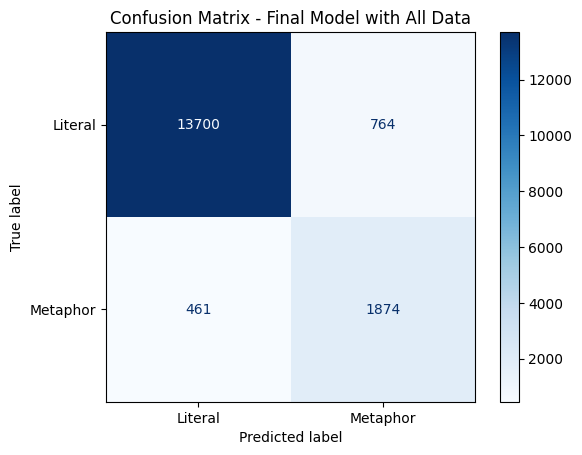

In [44]:
# Compute confusion matrix
cm = confusion_matrix(y_true_clean, y_pred_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Literal', 'Metaphor'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model with All Data")
plt.show()

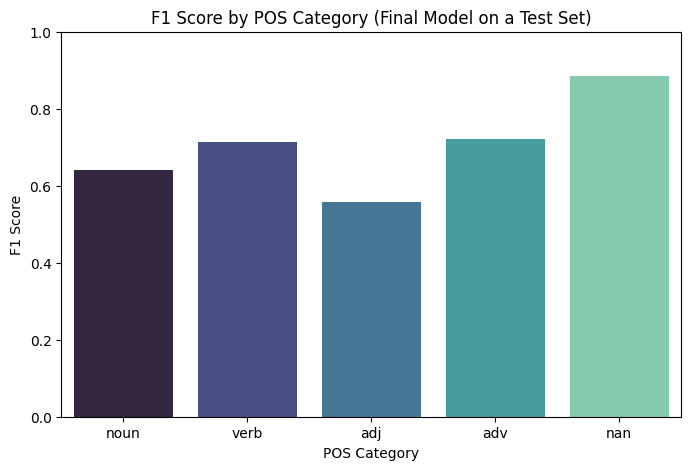

In [45]:
# # F1 Score by POS Category
# Prepare data for plotting
pos_labels = ['noun', 'verb', 'adj', 'adv','nan']
f1_scores = []
for pos in pos_labels:
    comparison_mask = np.array([p == pos or p == 'na' for p in aligned_pos_clean])
    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]
        f1 = precision_recall_fscore_support(y_true_sub, y_pred_sub, average=None, zero_division=0)[2]
        f1_scores.append(f1[1] if len(f1) > 1 else 0.0)
    else:
        f1_scores.append(0.0)
df_f1 = pd.DataFrame({'POS': pos_labels, 'F1 Score': f1_scores})
plt.figure(figsize=(8, 5))
sns.barplot(x='POS', y='F1 Score', data=df_f1, palette='mako')
plt.title('F1 Score by POS Category (Final Model on a Test Set)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.xlabel('POS Category')
plt.show()

how to handle pos and met_type imbalance

## extension to russian


“We fine‑tune a multilingual encoder (XLM‑RoBERTa) on English VUAMC for token‑level metaphor detection, and then reuse it as a frozen encoder for cross‑lingual sentence‑level metaphor identification in English and Russian SVO/Adj‑N constructions.”

In [46]:
# List ALL sheets in the Excel file
excel_file = pd.ExcelFile('Datasets_ACL2014.xlsx')
print("Available sheets:")
for sheet in excel_file.sheet_names:
    print(f"  - {sheet}")

Available sheets:
  - LIT_SVO_EN
  - MET_SVO_EN
  - LIT_AN_EN
  - MET_AN_EN
  - MET_SVO_RU
  - LIT_SVO_RU
  - MET_AN_RU
  - LIT_AN_RU


In [47]:
import pandas as pd

def load_acl2014_sheets(file_path):
    """
    Load EXACT sheets from your Datasets_ACL2014.xlsx
    - LIT_* → label=0, MET_* → label=1
    - AN = AdjN, SVO = SVO
    """
    sheet_configs = [
        # (sheet_name, lang, construction)
        ('LIT_SVO_EN', 'EN', 'SVO'),
        ('MET_SVO_EN', 'EN', 'SVO'),
        ('LIT_SVO_RU', 'RU', 'SVO'),
        ('MET_SVO_RU', 'RU', 'SVO'),
        ('LIT_AN_EN',  'EN', 'AdjN'),
        ('MET_AN_EN',  'EN', 'AdjN'),
        ('LIT_AN_RU',  'RU', 'AdjN'),
        ('MET_AN_RU',  'RU', 'AdjN'),
    ]

    all_rows = []

    for sheet_name, lang, constr in sheet_configs:
        print(f"Loading {sheet_name}...")
        df = pd.read_excel(file_path, sheet_name=sheet_name)

        # Label: 1 if MET_*, else 0
        label = 1 if sheet_name.startswith('MET_') else 0

        # Build phrase based on construction
        if constr == 'SVO':
            # SVO sheets have subject, verb, object
            phrase = (df['subject'].fillna('') + ' ' +
                     df['verb'].fillna('') + ' ' +
                     df['object'].fillna('')).str.strip()
        else:  # AdjN
            # AN sheets have adj, noun
            phrase = (df['adj'].fillna('') + ' ' +
                     df['noun'].fillna('')).str.strip()

        # Full input: "phrase | sentence"
        text = (phrase + ' | ' + df['sentence'].fillna('')).str.strip()

        tmp_df = pd.DataFrame({
            'text': text,
            'label': label,
            'lang': lang,
            'construction': constr
        })

        # Filter out empty/short texts
        tmp_df = tmp_df[tmp_df['text'].str.len() > 10]
        all_rows.append(tmp_df)
        print(f"  → {len(tmp_df)} examples (label={label})")

    acl_df = pd.concat(all_rows, ignore_index=True)
    return acl_df

# Load it!
acl_df = load_acl2014_sheets('Datasets_ACL2014.xlsx')
print(f"\n=== FINAL DATASET ===")
print(f"Total: {len(acl_df)} examples")
print("\nDistribution:")
print(acl_df.groupby(['lang', 'construction', 'label']).size().unstack(fill_value=0))

print("\nSample rows:")
print(acl_df.head())


Loading LIT_SVO_EN...
  → 111 examples (label=0)
Loading MET_SVO_EN...
  → 111 examples (label=1)
Loading LIT_SVO_RU...
  → 120 examples (label=0)
Loading MET_SVO_RU...
  → 120 examples (label=1)
Loading LIT_AN_EN...
  → 100 examples (label=0)
Loading MET_AN_EN...
  → 100 examples (label=1)
Loading LIT_AN_RU...
  → 112 examples (label=0)
Loading MET_AN_RU...
  → 100 examples (label=1)

=== FINAL DATASET ===
Total: 874 examples

Distribution:
label                0    1
lang construction          
EN   AdjN          100  100
     SVO           111  111
RU   AdjN          112  100
     SVO           120  120

Sample rows:
                                                                              text  \
0          stranger approach | She hated strangers approaching her for any reason.   
1  smoke arise | The camp smoke arose from the usual places as far as I could see.   
2                                         bus arrive | The bus eventually arrived.   
3                         at

In [48]:
acl_df.head()

,text,label,lang,construction
0,stranger approach | She hated strangers approaching her for any reason.,0,EN,SVO
1,smoke arise | The camp smoke arose from the usual places as far as I could see.,0,EN,SVO
2,bus arrive | The bus eventually arrived.,0,EN,SVO
3,attach hose | Attach a drain hose to the radiator drain.,0,EN,SVO
4,pirate attack ship | Somali pirates have attacked 62 ships.,0,EN,SVO


In [51]:
def get_sentence_embeddings_from_token_model(texts, model, tokenizer, max_length=64,
                                             device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    embeddings = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                max_length=max_length,
                padding=True
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Call the encoder inside the classifier
            # For XLMRobertaForTokenClassification, this is usually .roberta
            encoder_outputs = model.roberta(**inputs)
            cls_emb = encoder_outputs.last_hidden_state[:, 0, :]  # [CLS]
            embeddings.append(cls_emb.cpu().numpy()[0])

    return np.array(embeddings)

print("Extracting embeddings from model_balanced encoder...")
acl_embeddings = get_sentence_embeddings_from_token_model(
    acl_df['text'].tolist(),
    model_balanced,
    tokenizer  # the tokenizer you used for VUAMC
)
acl_df['embedding'] = list(acl_embeddings)
print("✅ Embeddings extracted!")


Extracting embeddings from model_balanced encoder...
✅ Embeddings extracted!


In [52]:
acl_df.head()

,text,label,lang,construction,embedding
0,stranger approach | She hated strangers approaching her for any reason.,0,EN,SVO,"[0.19228898, 0.102974296, -0.18536134, -0.067895055, 0.21991466, -0.14255115, -0.06920344, 0.03277415, 0.118688315, -0.19183114, 0.20345551, 0.29753754, -0.07952915, -0.0015565609, 0.16562115, 0.09337928, 0.023302322, -0.115713246, 0.18510447, 0.32300228, 0.061250426, 0.12870559, 0.17594866, 0.16916181, -0.16236345, 0.14864576, -0.15309064, -0.080588356, 0.16641152, -0.07906463, 0.17420214, 0.042305138, -0.013902583, 0.3284082, 0.17663313, 0.0014009258, -0.405356, -0.2698584, -0.16854706, 0.15226518, 0.09589892, 0.33360362, 0.17826436, -0.1735205, 0.039580416, -0.33961457, -0.06387973, -0.039341416, -0.13733225, -0.28225562, 0.28038278, 0.09500505, 0.03760542, 0.25343636, -0.15999274, -0.16082923, 0.26480862, 0.014331793, -0.18830985, 0.40859002, -0.08552538, 0.2457507, 0.17540509, 0.12801939, 0.58024544, -0.3527891, -0.26634106, -0.14951247, -0.045204673, -0.18331988, -0.1176537, -0.4179609, -0.09728174, 0.08585263, -0.39447334, -0.08017174, -0.18476126, 0.3673469, -0.08877721, 0.15296793, 0.090115584, 0.12977688, -0.06284507, -0.20623714, 0.0117506245, 0.056807287, 0.070832595, 0.43658933, 0.040877003, 0.06381694, 0.10879793, 0.16810013, -0.2122264, -0.26017007, -0.16856153, -0.024119053, 0.16363682, -0.1929808, 0.012048747, -0.1229229, ...]"
1,smoke arise | The camp smoke arose from the usual places as far as I could see.,0,EN,SVO,"[0.19746786, 0.013986566, -0.28012082, -0.06385076, 0.015443419, -0.05119514, 0.04663772, 0.052939754, 0.12920828, -0.21825391, 0.21198979, 0.3102117, -0.062060148, -0.013743214, 0.10480913, 0.15807062, -0.02163933, -0.0844229, 0.28000772, 0.21707918, 0.124010205, 0.08296674, 0.16918896, 0.08811853, -0.25592387, 0.071275905, -0.23977852, -0.051968895, 0.1342608, -0.021501806, 0.1420137, 0.09273806, 0.1368696, 0.24634318, 0.20245989, -0.01763248, -0.30490142, -0.27575478, -0.1346699, 0.1578128, 0.12386719, 0.2486145, 0.054910492, -0.2195489, -0.069174625, -0.34011045, -0.05516231, -0.25097823, -0.12664165, -0.22433366, 0.3152635, -0.03885912, 0.06818009, 0.26908514, -0.1989951, -0.1631489, 0.18159392, 0.05987023, -0.15681992, 0.3247962, -0.053947855, 0.16769251, 0.22356059, 0.12715435, 0.49314895, -0.30116296, -0.28814104, -0.19370656, -0.098344155, -0.2337845, -0.1853191, -0.3123775, -0.08437106, 0.014702871, -0.26706088, -0.052460294, -0.28685474, 0.30280927, 0.074505806, 0.13795684, 0.117202856, 0.08503093, -0.093366034, -0.03501643, -0.025578534, 0.19898033, 0.04603853, 0.36080295, 0.015064425, 0.06118486, -0.004376347, 0.18630916, -0.13033302, -0.24372058, -0.16586384, 0.08569679, 0.06012489, -0.14403608, -0.008672177, -0.101609424, ...]"
2,bus arrive | The bus eventually arrived.,0,EN,SVO,"[0.20674272, 0.044510916, -0.2002248, 0.015449358, 0.03770042, -0.08170826, -0.038880333, 0.05771179, 0.08131635, -0.2304485, 0.12793452, 0.2674409, -0.07802827, -0.119306274, 0.14145398, 0.09885829, 0.027600583, -0.08139252, 0.1833017, 0.272511, 0.13334335, 0.1280597, 0.20424126, 0.18369819, -0.07531205, 0.066819504, -0.2125352, -0.03864812, 0.09618069, 0.0025981518, 0.16485941, 0.021793202, -0.019734, 0.32468003, 0.16743559, 0.04237574, -0.35491458, -0.28345263, -0.09138572, 0.14899342, 0.06756538, 0.23236519, 0.23435885, -0.10257562, 0.0073392265, -0.4034315, -0.07876296, -0.15483017, -0.20461728, -0.2527248, 0.30391994, 0.032143343, 0.060966436, 0.22579032, -0.054025214, -0.07245094, 0.18381791, -0.030949475, -0.17342207, 0.3817389, -0.15083382, 0.14359704, 0.16366348, 0.07623397, 0.49268273, -0.21756156, -0.2123705, -0.1420634, -0.055235587, -0.17543583, -0.12831284, -0.34840542, -0.026288556, 0.0037638866, -0.36958024, -0.016204111, -0.13020891, 0.27169627, -0.043930344, 0.11676596, 0.07087126, 0.14249071, -0.08495785, -0.08198844, -0.08870019, 0.15507272, 0.106860206, 0.3109406, -0.022163529, 0.0366845, 0.022769148, 0.20380308, -0.23358747, -0.2241726, -0.1360235, 0.013936677, 

In [53]:
def evaluate_transfer(lang, construction):
    """Train linear head and evaluate on one language/construction split"""
    subset = acl_df[(acl_df['lang'] == lang) & (acl_df['construction'] == construction)]

    if len(subset) < 20:
        print(f"⚠️  Skipping {lang}-{construction}: too few examples ({len(subset)})")
        return None

    print(f"\n=== {lang.upper()}-{construction}: {len(subset)} examples ===")

    X = np.stack(subset['embedding'].values)
    y = subset['label'].values

    # 80/20 split (train linear head / test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Train linear head (1 minute)
    clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Test
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(classification_report(y_test, y_pred, target_names=['Literal', 'Metaphor']))
    return {
        'lang': lang,
        'construction': construction,
        'n_train': len(X_train),
        'n_test': len(X_test),
        'f1': f1,
        'support_metaphor': sum(y_test)
    }

# Run full evaluation matrix
results = []
for lang in ['EN', 'RU']:
    for constr in ['SVO', 'AdjN']:
        result = evaluate_transfer(lang, constr)
        if result:
            results.append(result)

results_df = pd.DataFrame(results)
print("\n=== VUAMC → SVO/AdjN TRANSFER SUMMARY ===")
print(results_df.pivot(index='construction', columns='lang', values='f1').round(3))



=== EN-SVO: 222 examples ===
              precision    recall  f1-score   support

     Literal       0.95      0.78      0.86        23
    Metaphor       0.81      0.95      0.88        22

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.88      0.87      0.87        45


=== EN-AdjN: 200 examples ===
              precision    recall  f1-score   support

     Literal       0.94      0.75      0.83        20
    Metaphor       0.79      0.95      0.86        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40


=== RU-SVO: 240 examples ===
              precision    recall  f1-score   support

     Literal       0.86      1.00      0.92        24
    Metaphor       1.00      0.83      0.91        24

    accuracy                           0.92        48
   macro avg       0.93      0.92    

## Model explainability

### Attention visualization (does it focus on metaphorical tokens?)